<a href="https://colab.research.google.com/github/Samyam30/MLCourseProject/blob/main/MLProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samyambudhathoki","key":"e1433c9848e31d73524fc485693f390b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d asjad99/mimiciii

Dataset URL: https://www.kaggle.com/datasets/asjad99/mimiciii
License(s): CC0-1.0
  0% 0.00/10.6M [00:00<?, ?B/s]
100% 10.6M/10.6M [00:00<00:00, 1.21GB/s]


In [ ]:
!unzip mimiciii.zip

Archive:  mimiciii.zip
  inflating: mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/CALLOUT.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/CAREGIVERS.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/CPTEVENTS.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/DATETIMEEVENTS.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/DIAGNOSES_ICD.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/DRGCODES.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/D_CPT.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/D_ICD_DIAGNOSES.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/D_ICD_PROCEDURES.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/D_ITEMS.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/D_LABITEMS.csv  
  inflating: mimic-iii-clinical-database-demo-1.4/ICUSTAYS.csv  
  inflating: mimic-iii-clinical-data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

files = {
    "chartevents": ("/content/mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv",
                    ["icustay_id", "charttime", "itemid", "valuenum"]),
    "labevents": ("/content/mimic-iii-clinical-database-demo-1.4/LABEVENTS.csv",
                  ["subject_id", "hadm_id", "charttime", "itemid", "valuenum"]),
    "outputevents": ("/content/mimic-iii-clinical-database-demo-1.4/OUTPUTEVENTS.csv",
                     ["subject_id", "hadm_id", "charttime", "itemid", "value"]),
    "admissions": ("/content/mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv",
                   ["subject_id", "admittime"])
}
dfs = {name: pd.read_csv(path, usecols=cols, low_memory=False) for name, (path, cols) in files.items()}
df_chartevents = dfs["chartevents"]
df_labevents = dfs["labevents"]
df_outputevents = dfs["outputevents"]
df_admissions = dfs["admissions"]

In [ ]:
#glasgow coma scale, used to measure consciousness
gcs_items = {
    "GCSVerbal": [723, 223900],
    "GCSMotor": [454, 223901],
    "GCSEyes": [184, 220739]
}
df_gcs = df_chartevents[df_chartevents["itemid"].isin(sum(gcs_items.values(), []))].copy()
df_gcs["Feature"] = df_gcs["itemid"].map({v: k for k, lst in gcs_items.items() for v in lst})
df_gcs = df_gcs.pivot_table(index=["icustay_id", "charttime"], columns="Feature", values="valuenum", aggfunc="max")
df_gcs["GCS_Total"] = df_gcs.sum(axis=1)
df_gcs.reset_index(inplace=True)

In [ ]:
vital_signs = {
    "SysBP": [51, 442, 455, 220179, 220050],
    "HeartRate": [211, 220045],
    "Temperature_F": [678, 223761]
}
df_vitals = df_chartevents[df_chartevents["itemid"].isin(sum(vital_signs.values(), []))].copy()
df_vitals["Feature"] = df_vitals["itemid"].map({v: k for k, lst in vital_signs.items() for v in lst})
df_vitals = df_vitals.pivot_table(index=["icustay_id", "charttime"], columns="Feature", values="valuenum", aggfunc="max")
df_vitals["Temperature_C"] = (df_vitals["Temperature_F"] - 32) * 5 / 9
df_vitals.drop(columns=["Temperature_F"], inplace=True)
df_vitals.reset_index(inplace=True)

In [ ]:
df_labevents = pd.read_csv("/content/mimic-iii-clinical-database-demo-1.4/LABEVENTS.csv", low_memory=False)
df_pao2 = df_labevents[df_labevents["itemid"] == 50821].copy()
df_pao2["Feature"] = "PaO2"
df_pao2 = df_pao2.pivot_table(index=["subject_id", "hadm_id", "charttime"], columns="Feature", values="valuenum", aggfunc="max")
df_pao2.reset_index(inplace=True)
df_chartevents = pd.read_csv("/content/mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv", low_memory=False)
fio2_items = [223835, 190]
df_fio2 = df_chartevents[df_chartevents["itemid"].isin(fio2_items)].copy()
df_fio2["Feature"] = "FiO2"
df_fio2 = df_fio2.pivot_table(index=["subject_id", "hadm_id", "charttime"], columns="Feature", values="valuenum", aggfunc="max")
df_fio2.reset_index(inplace=True)
df_pao2_fio2 = pd.merge(df_pao2, df_fio2, on=["subject_id", "hadm_id", "charttime"], how="outer")
df_pao2_fio2["PaO2_FiO2_Ratio"] = df_pao2_fio2["PaO2"] / df_pao2_fio2["FiO2"]
df_pao2_fio2["PaO2_FiO2_Ratio"] = df_pao2_fio2["PaO2_FiO2_Ratio"].fillna(df_pao2_fio2["PaO2"])
df_pao2_fio2.to_csv("processed_pao2_fio2.csv", index=False)

In [ ]:
urine_items = [40055, 43175, 40069, 40094, 40715, 40473, 40085, 40057, 40056]
df_urine = df_outputevents[df_outputevents["itemid"].isin(urine_items)].copy()
if "valuenum" in df_urine.columns:
    value_column = "valuenum"
elif "value" in df_urine.columns:
    value_column = "value"
else:
    raise KeyError("⚠ No valid urine output column found in OUTPUTEVENTS.csv!")
df_urine = df_urine.groupby(["subject_id", "hadm_id", "charttime"])[value_column].sum().reset_index()
df_urine.rename(columns={value_column: "UrineOutput"}, inplace=True)

In [ ]:
lab_items = {
    "WBC": [51300],
    "Bicarbonate": [50882],
    "Sodium": [950824, 50983],
    "Potassium": [50822, 50971],
    "Bilirubin": [50885],
    "BUN": [51006]
}
df_labs = df_labevents[df_labevents["itemid"].isin(sum(lab_items.values(), []))].copy()
df_labs["Feature"] = df_labs["itemid"].map({v: k for k, lst in lab_items.items() for v in lst})
df_labs = df_labs.pivot_table(index=["subject_id", "hadm_id", "charttime"],
                              columns="Feature", values="valuenum", aggfunc="max")
df_labs.reset_index(inplace=True)

In [ ]:
dfs = [df_gcs, df_vitals, df_pao2_fio2, df_urine, df_labs]
for i, df in enumerate(dfs):
    for col in ["subject_id", "hadm_id", "charttime"]:
        if col not in df.columns:
            df[col] = pd.NA
    for col in ["subject_id", "hadm_id"]:
        if df[col].dtype != 'int64':
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    if df["charttime"].dtype != '<M8[ns]':
        df["charttime"] = pd.to_datetime(df["charttime"])
    dfs[i] = df
df_merged = dfs[0]
for df in dfs[1:]:
    df_merged = df_merged.merge(df, on=["subject_id", "hadm_id", "charttime"], how="outer")

print("Merging completed successfully!")


Merging completed successfully!


In [ ]:
df_merged.sort_values(["subject_id", "hadm_id", "charttime"], inplace=True)
df_merged.ffill(inplace=True)
df_merged.bfill(inplace=True)
df_merged.fillna(df_merged.median(), inplace=True)
outlier_bounds = {
    "SysBP": (50, 250),
    "HeartRate": (30, 200),
    "Temperature_C": (30, 42),
    "PaO2_FiO2_Ratio": (50, 600),
    "UrineOutput": (0, 8000),
    "WBC": (2, 30),
    "Bicarbonate": (5, 45),
    "Sodium": (120, 160),
    "Potassium": (2, 7),
    "Bilirubin": (0.1, 50),
    "BUN": (2, 200),
    "GCS_Total": (3, 15)
}
for col, (low, high) in outlier_bounds.items():
    if col in df_merged.columns:
        df_merged[col] = np.clip(df_merged[col], low, high)

print("Data sorting and cleaning completed successfully!")

Data sorting and cleaning completed successfully!


In [ ]:
df_merged.to_csv("processed_feature_set_A.csv", index=False)

print("Feature extraction and preprocessing completed. Data saved to 'processed_feature_set_A.csv'.")

Feature extraction and preprocessing completed. Data saved to 'processed_feature_set_A.csv'.


In [ ]:
df_final = pd.read_csv("processed_feature_set_A.csv")
df_admissions = pd.read_csv("/content/mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv",
                            usecols=["subject_id", "hadm_id", "deathtime", "dischtime"])
df_icustays = pd.read_csv("/content/mimic-iii-clinical-database-demo-1.4/ICUSTAYS.csv",
                          usecols=["subject_id", "hadm_id", "intime"])
df_patients = pd.read_csv("/content/mimic-iii-clinical-database-demo-1.4/PATIENTS.csv",
                          usecols=["subject_id", "dod"])
df_admissions["deathtime"] = pd.to_datetime(df_admissions["deathtime"])
df_admissions["dischtime"] = pd.to_datetime(df_admissions["dischtime"])
df_icustays["intime"] = pd.to_datetime(df_icustays["intime"])
df_patients["dod"] = pd.to_datetime(df_patients["dod"])
df_final = df_final.merge(df_admissions, on=["subject_id", "hadm_id"], how="left")
df_final = df_final.merge(df_patients, on="subject_id", how="left")
df_final = df_final.merge(df_icustays, on=["subject_id", "hadm_id"], how="left")
df_final["Mortality"] = df_final["deathtime"].notnull().astype(int)
df_final["Mortality_48h"] = ((df_final["dod"] - df_final["intime"]).dt.total_seconds() / 3600 < 48).astype(int)
df_final["Mortality_30d"] = ((df_final["dod"] - df_final["dischtime"]).dt.days < 30).astype(int)
df_final.drop(columns=["deathtime", "dischtime", "dod", "intime"], inplace=True)
df_final.to_csv("final_dataset_with_mortality.csv", index=False)
print(df_final[["Mortality", "Mortality_48h", "Mortality_30d"]].sum())
print(df_final.head())
print("Mortality label addition successfully completed!")

Mortality        5777
Mortality_48h     275
Mortality_30d    6517
dtype: int64
   icustay_id_x            charttime  GCSEyes  GCSMotor  GCSVerbal  GCS_Total  \
0      254635.0  2164-10-23 17:38:00      3.0       4.0        4.0       11.0   
1      254635.0  2164-10-24 00:00:00      3.0       4.0        4.0       11.0   
2      254635.0  2164-10-24 03:00:00      3.0       4.0        4.0       11.0   
3      254635.0  2164-10-25 03:00:00      3.0       4.0        4.0       11.0   
4      254635.0  2164-10-25 09:30:00      3.0       4.0        4.0       11.0   

   subject_id  hadm_id  icustay_id_y  HeartRate  ...  UrineOutput   BUN  \
0       10006   142345      254635.0       72.0  ...        100.0   9.0   
1       10006   142345      254635.0       72.0  ...        100.0   9.0   
2       10006   142345      254635.0       72.0  ...        100.0  11.0   
3       10006   142345      254635.0       72.0  ...         10.0  11.0   
4       10006   142345      254635.0       72.0  ...       

In [ ]:
mortality_0 = df_final[df_final['Mortality'] == 0]
mortality_1 = df_final[df_final['Mortality'] == 1]

In [ ]:
mortality_0 = mortality_0.sample(frac=1, random_state=42).reset_index(drop=True)
mortality_1 = mortality_1.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
num_clients = 10

In [ ]:
def create_non_iid_distribution(data_0, data_1, num_clients, alpha=0.8):
    np.random.seed(None)
    data = pd.concat([data_0, data_1]).sample(frac=1, random_state=42).reset_index(drop=True)
    min_samples_per_client = 2
    total_samples = len(data)
    remaining_samples = total_samples - (num_clients * min_samples_per_client)
    proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
    counts = (proportions * remaining_samples).astype(int)
    counts[-1] += remaining_samples - counts.sum()
    counts += min_samples_per_client
    client_data = []
    start_idx = 0
    for i in range(num_clients):
        end_idx = start_idx + counts[i]
        client_df = data.iloc[start_idx:end_idx].sample(frac=1, random_state=i)
        client_data.append(client_df.reset_index(drop=True))
        start_idx = end_idx
    return client_data

In [ ]:
client_data = create_non_iid_distribution(mortality_0, mortality_1, num_clients, alpha=0.8)

Distribution of classes across clients:
Client 1:
  Class 0 (Survived): 926 samples (79.2%)
  Class 1 (Died): 243 samples (20.8%)
  Total: 1169 samples
------------------------------
Client 2:
  Class 0 (Survived): 5110 samples (80.0%)
  Class 1 (Died): 1275 samples (20.0%)
  Total: 6385 samples
------------------------------
Client 3:
  Class 0 (Survived): 5340 samples (80.2%)
  Class 1 (Died): 1315 samples (19.8%)
  Total: 6655 samples
------------------------------
Client 4:
  Class 0 (Survived): 1644 samples (79.9%)
  Class 1 (Died): 414 samples (20.1%)
  Total: 2058 samples
------------------------------
Client 5:
  Class 0 (Survived): 1078 samples (79.1%)
  Class 1 (Died): 285 samples (20.9%)
  Total: 1363 samples
------------------------------
Client 6:
  Class 0 (Survived): 2378 samples (79.5%)
  Class 1 (Died): 612 samples (20.5%)
  Total: 2990 samples
------------------------------
Client 7:
  Class 0 (Survived): 329 samples (79.1%)
  Class 1 (Died): 87 samples (20.9%)
  Tota

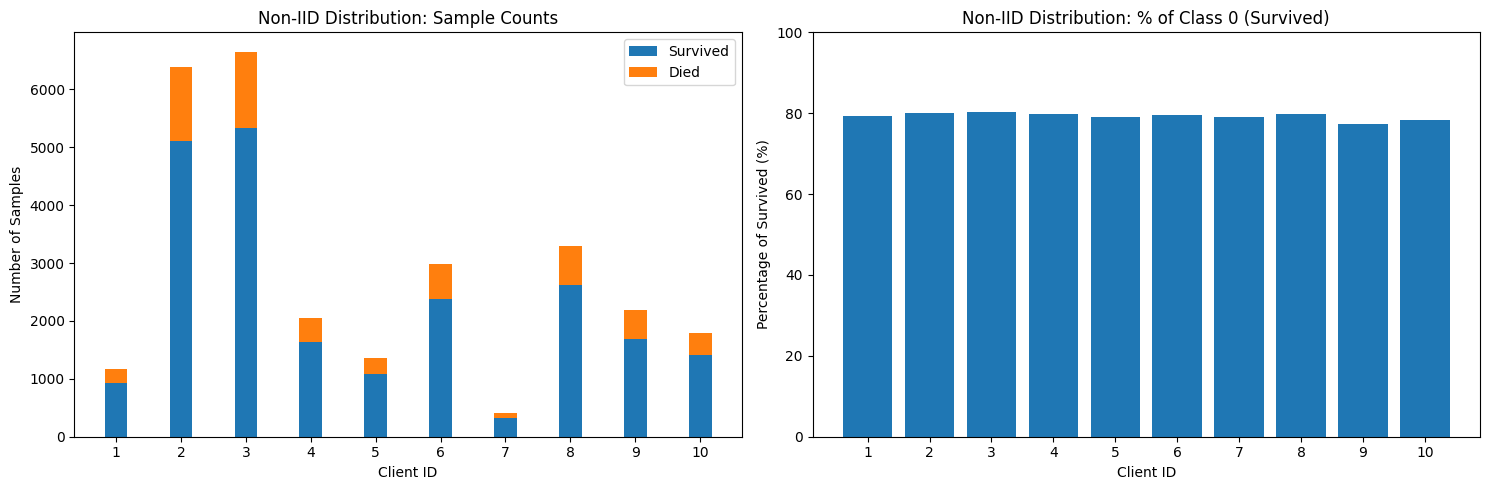

Non-IID data partitioning complete with 10 clients.


In [ ]:
def visualize_distribution(client_data):
    class_0_counts = []
    class_1_counts = []
    class_0_percent = []
    total_samples = []
    print("Distribution of classes across clients:")
    for i, client in enumerate(client_data):
        counts = client['Mortality'].value_counts().to_dict()
        count_0 = counts.get(0, 0)
        count_1 = counts.get(1, 0)
        total = len(client)
        class_0_counts.append(count_0)
        class_1_counts.append(count_1)
        class_0_percent.append(100 * count_0 / total)
        total_samples.append(total)
        print(f"Client {i+1}:")
        print(f"  Class 0 (Survived): {count_0} samples ({count_0/total:.1%})")
        print(f"  Class 1 (Died): {count_1} samples ({count_1/total:.1%})")
        print(f"  Total: {total} samples")
        print("-" * 30)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    x = np.arange(num_clients)
    width = 0.35
    ax1.bar(x, class_0_counts, width, label='Survived')
    ax1.bar(x, class_1_counts, width, bottom=class_0_counts, label='Died')
    ax1.set_xlabel('Client ID')
    ax1.set_ylabel('Number of Samples')
    ax1.set_title('Non-IID Distribution: Sample Counts')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'{i+1}' for i in range(num_clients)])
    ax1.legend()
    ax2.bar(x, class_0_percent)
    ax2.set_xlabel('Client ID')
    ax2.set_ylabel('Percentage of Survived (%)')
    ax2.set_title('Non-IID Distribution: % of Class 0 (Survived)')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{i+1}' for i in range(num_clients)])
    ax2.set_ylim(0, 100)
    plt.tight_layout()
    plt.savefig('non_iid_distribution.png', dpi=300)
    plt.show()
visualize_distribution(client_data)
for i, client_df in enumerate(client_data):
    client_df.to_csv(f"client_{i+1}_data.csv", index=False)
print(f"Non-IID data partitioning complete with {num_clients} clients.")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
        nn.init.xavier_uniform_(self.layer_2.weight)
        self.dropout = nn.Dropout(dropout_prob)
    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = self.dropout(x)
        x = self.layer_2(x)
        return x

In [ ]:
class FederatedClient:
    def __init__(self, client_id, train_data, test_data, input_dim, hidden_dim, output_dim, dropout_prob=0.5, lr=0.001):
        self.client_id = client_id
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout_prob = dropout_prob
        self.lr = lr
        self.train_loader = self._prepare_data(train_data)
        self.test_loader = self._prepare_data(test_data)
        self.model = NeuralNetwork(input_dim, hidden_dim, output_dim, dropout_prob)
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def _prepare_data(self, data):
        features, labels = data
        dataset = TensorDataset(torch.tensor(features, dtype=torch.float32),
                               torch.tensor(labels, dtype=torch.float32).reshape(-1, 1))
        return DataLoader(dataset, batch_size=32, shuffle=True)

    def train(self, global_model_weights):
        self.model.load_state_dict(global_model_weights)
        self.model.train()
        for epoch in range(10):
            for batch_x, batch_y in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
        return self.model.state_dict()
    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in self.test_loader:
                outputs = self.model(batch_x)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        accuracy = 100 * correct / total
        return accuracy
    def evaluate_train(self):
      self.model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          for batch_x, batch_y in self.train_loader:
              outputs = self.model(batch_x)
              predicted = (torch.sigmoid(outputs) > 0.5).float()
              total += batch_y.size(0)
              correct += (predicted == batch_y).sum().item()
      return 100 * correct / total
    def calculate_loss(self, data_loader):
      self.model.eval()
      total_loss = 0.0
      total_samples = 0

      with torch.no_grad():
          for batch_x, batch_y in data_loader:
              outputs = self.model(batch_x)
              loss = self.criterion(outputs, batch_y)
              total_loss += loss.item() * batch_y.size(0)
              total_samples += batch_y.size(0)

      return total_loss / total_samples

In [ ]:
class FederatedServer:
    def __init__(self, global_model, clients):
        self.global_model = global_model
        self.clients = clients

    def aggregate_weights(self, client_weights):
        global_weights = self.global_model.state_dict()
        for key in global_weights:
            global_weights[key] = torch.stack([client_weights[i][key] for i in range(len(client_weights))]).mean(0)

        return global_weights

    def run_federated_learning(self, num_rounds):
            client_weights = []
            for client in self.clients:
                print(f"Training {client.client_id}...")
                updated_weights = client.train(self.global_model.state_dict())
                client_weights.append(updated_weights)
                accuracy = client.evaluate()
                print(f"{client.client_id} Test Accuracy: {accuracy:.2f}%")
            global_weights = self.aggregate_weights(client_weights)
            self.global_model.load_state_dict(global_weights)
            global_accuracy = self.evaluate_global_model()
            print(f"Global Model Test Accuracy: {global_accuracy:.2f}%")

    def evaluate_global_model(self):
        self.global_model.eval()
        total_accuracy = 0
        for client in self.clients:
            correct = 0
            total = 0
            with torch.no_grad():
                for batch_x, batch_y in client.test_loader:
                    outputs = self.global_model(batch_x)
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    total += batch_y.size(0)
                    correct += (predicted == batch_y).sum().item()
            accuracy = 100 * correct / total
            total_accuracy += accuracy
        return total_accuracy / len(self.clients)

In [ ]:
def run_federated_learning_with_metrics_and_early_stopping(federated_server, max_rounds=10, patience=3, min_improvement=0.001):
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    history = []
    best_accuracy = 0
    rounds_without_improvement = 0
    for round_num in range(max_rounds):
        print(f"Round {round_num + 1}/{max_rounds}")
        client_weights = []
        round_train_accuracies = []
        round_test_accuracies = []
        round_train_losses = []
        round_test_losses = []
        for client in federated_server.clients:
            updated_weights = client.train(federated_server.global_model.state_dict())
            client_weights.append(updated_weights)
            train_acc = client.evaluate_train()
            test_acc = client.evaluate()
            train_loss = client.calculate_loss(client.train_loader)
            test_loss = client.calculate_loss(client.test_loader)
            round_train_accuracies.append(train_acc)
            round_test_accuracies.append(test_acc)
            round_train_losses.append(train_loss)
            round_test_losses.append(test_loss)
        global_weights = federated_server.aggregate_weights(client_weights)
        federated_server.global_model.load_state_dict(global_weights)
        avg_train_accuracy = sum(round_train_accuracies) / len(round_train_accuracies)
        avg_test_accuracy = sum(round_test_accuracies) / len(round_test_accuracies)
        avg_train_loss = sum(round_train_losses) / len(round_train_losses)
        avg_test_loss = sum(round_test_losses) / len(round_test_losses)
        train_accuracies.append(avg_train_accuracy)
        test_accuracies.append(avg_test_accuracy)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        global_accuracy = federated_server.evaluate_global_model()
        history.append(global_accuracy)
        if global_accuracy > best_accuracy + min_improvement:
            best_accuracy = global_accuracy
            rounds_without_improvement = 0
        else:
            rounds_without_improvement += 1
            print(f"No significant improvement. Rounds without improvement: {rounds_without_improvement}/{patience}")
            if rounds_without_improvement >= patience:
                print(f"Early stopping after {round_num + 1} rounds")
                break
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title("Performance Evolution on Training and Test Sets")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.title("Loss Evolution During Federated Learning")
    plt.legend()
    plt.grid(True)
    plt.show()
    return train_accuracies, test_accuracies, train_losses, test_losses, history

Global model initialized with 17 input features and 64 hidden neurons
Client_1 initialized with 935 training samples and 234 test samples
Client_2 initialized with 5108 training samples and 1277 test samples
Client_3 initialized with 5324 training samples and 1331 test samples
Client_4 initialized with 1646 training samples and 412 test samples
Client_5 initialized with 1090 training samples and 273 test samples
Client_6 initialized with 2392 training samples and 598 test samples
Client_7 initialized with 332 training samples and 84 test samples
Client_8 initialized with 2629 training samples and 658 test samples
Client_9 initialized with 1751 training samples and 438 test samples
Client_10 initialized with 1432 training samples and 359 test samples
Federated server initialized

Starting federated learning...
Round 1/10
Round 2/10
Round 3/10
Round 4/10
No significant improvement. Rounds without improvement: 1/3
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10


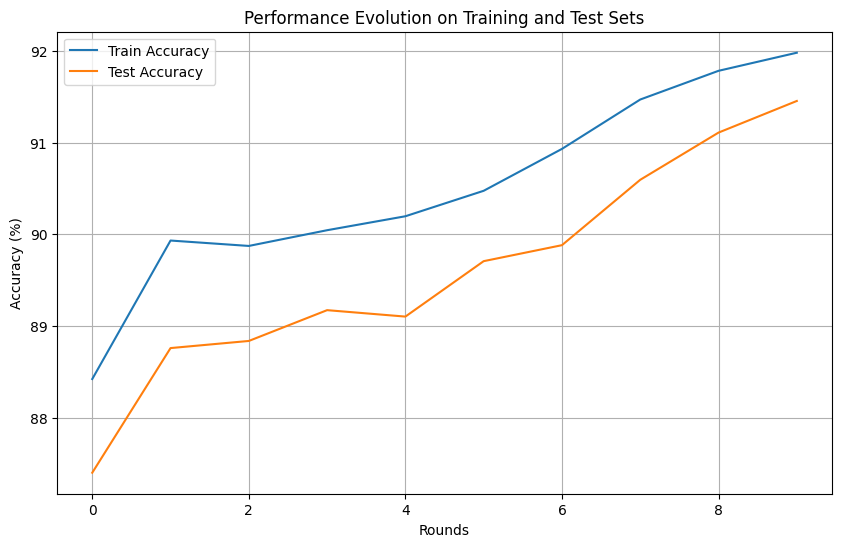

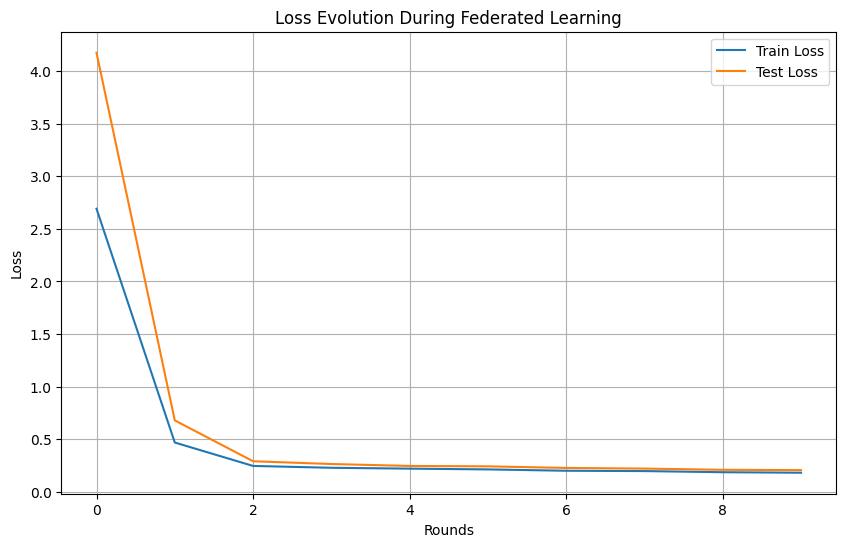

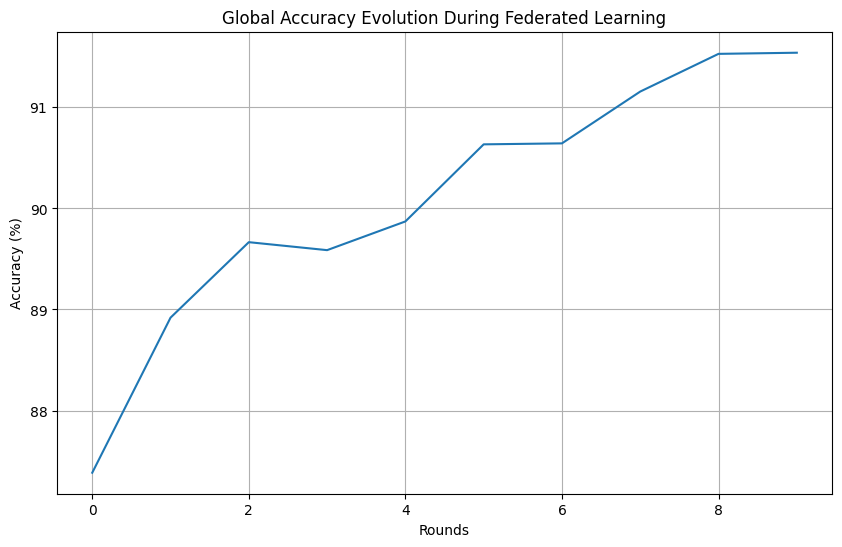

In [ ]:
client_datasets = []
for client_df in client_data:
    X = client_df.drop(['Mortality', 'Mortality_48h', 'Mortality_30d', 'icustay_id_x', 'charttime', 'subject_id', 'hadm_id', 'icustay_id_y'], axis=1).values
    y = client_df['Mortality'].values
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    client_datasets.append(((X_train, y_train), (X_test, y_test)))
if len(client_datasets) > 0 and len(client_datasets[0]) > 0:
    input_dim = client_datasets[0][0][0].shape[1]
    hidden_dim = 64
    output_dim = 1
global_model = NeuralNetwork(input_dim, hidden_dim, output_dim, dropout_prob=0.3)
print(f"Global model initialized with {input_dim} input features and {hidden_dim} hidden neurons")
federated_clients = []
for i, dataset in enumerate(client_datasets):
    client = FederatedClient(
        client_id=f"Client_{i+1}",
        train_data=dataset[0],
        test_data=dataset[1],
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        dropout_prob=0.3,
        lr=0.001
    )
    federated_clients.append(client)
    print(f"Client_{i+1} initialized with {len(dataset[0][0])} training samples and {len(dataset[1][0])} test samples")
federated_server = FederatedServer(global_model, federated_clients)
print("Federated server initialized")
print("\nStarting federated learning...")
train_accuracies, test_accuracies, train_losses, test_losses, history = run_federated_learning_with_metrics_and_early_stopping(federated_server, max_rounds=10, patience=3)
plt.figure(figsize=(10, 6))
plt.plot(history)
plt.title('Global Accuracy Evolution During Federated Learning')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

=== Federated Model Evaluation ===
Client_1: Accuracy = 0.9017 (on 234 samples)
Client_2: Accuracy = 0.9303 (on 1277 samples)
Client_3: Accuracy = 0.9189 (on 1331 samples)
Client_4: Accuracy = 0.9199 (on 412 samples)
Client_5: Accuracy = 0.9341 (on 273 samples)
Client_6: Accuracy = 0.9197 (on 598 samples)
Client_7: Accuracy = 0.8929 (on 84 samples)
Client_8: Accuracy = 0.9164 (on 658 samples)
Client_9: Accuracy = 0.9064 (on 438 samples)
Client_10: Accuracy = 0.9053 (on 359 samples)

=== Global Results ===
Weighted Average Accuracy: 0.9191
Global Accuracy: 0.9206
Precision: 0.8161
Recall: 0.7755
F1 Score: 0.7953

=== Training a Centralized Model (Reference) ===
Epoch 2/10, Loss: 4.5049
Epoch 4/10, Loss: 0.9429
Epoch 6/10, Loss: 0.4372
Epoch 8/10, Loss: 0.3136
Epoch 10/10, Loss: 0.2864

=== Centralized Model Results ===
Accuracy: 0.8969
Precision: 0.7588
Recall: 0.7063
F1 Score: 0.7316


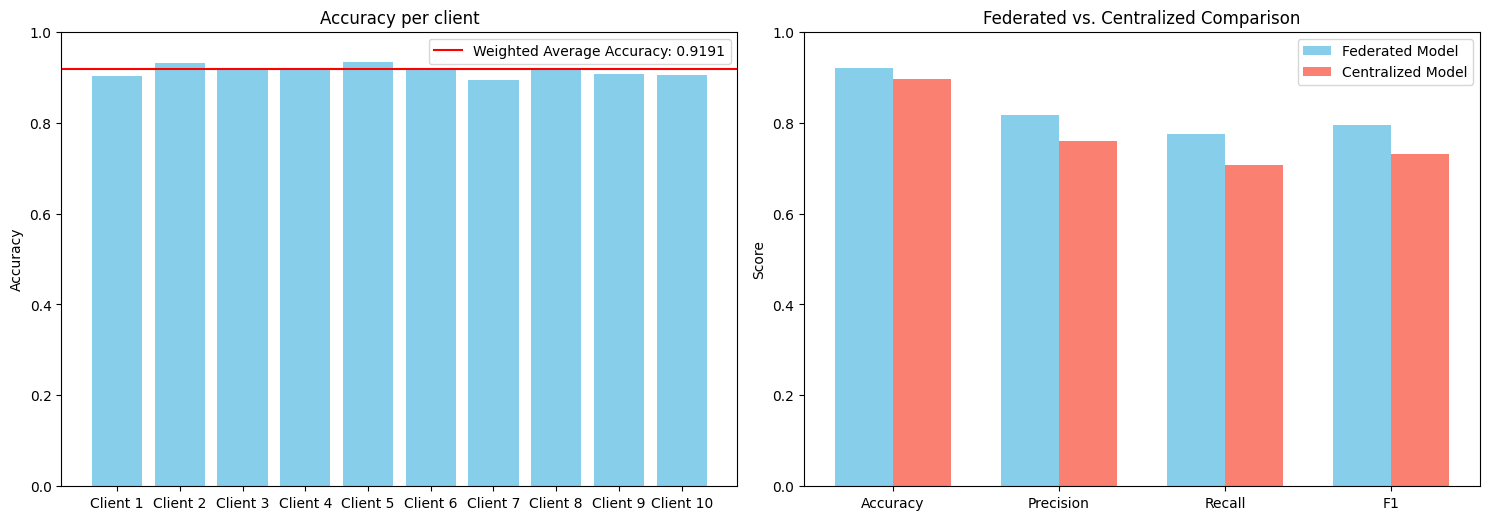

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_raw_data(self):
    X_test_list = []
    y_test_list = []
    for features, labels in self.test_loader:
        X_test_list.append(features.numpy())
        y_test_list.append(labels.numpy())
    X_test = np.vstack(X_test_list)
    y_test = np.vstack(y_test_list).reshape(-1)
    return X_test, y_test
FederatedClient.get_raw_data = get_raw_data
def evaluate_federated_model():
    print("=== Federated Model Evaluation ===")
    client_accuracies = []
    client_sizes = []
    all_y_true = []
    all_y_pred = []
    for client in federated_clients:
        local_accuracy = client.evaluate() / 100
        X_test, y_test = client.get_raw_data()
        client_sizes.append(len(X_test))
        client.model.load_state_dict(global_model.state_dict())
        client.model.eval()
        with torch.no_grad():
            outputs = client.model(torch.tensor(X_test, dtype=torch.float32))
            y_pred = (torch.sigmoid(outputs) > 0.5).float().numpy().reshape(-1)
        client_accuracies.append(local_accuracy)
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        print(f"{client.client_id}: Accuracy = {local_accuracy:.4f} (on {len(X_test)} samples)")
    weighted_avg_accuracy = sum(acc * size for acc, size in zip(client_accuracies, client_sizes)) / sum(client_sizes)
    global_accuracy = accuracy_score(all_y_true, all_y_pred)
    global_precision = precision_score(all_y_true, all_y_pred, zero_division=0)
    global_recall = recall_score(all_y_true, all_y_pred, zero_division=0)
    global_f1 = f1_score(all_y_true, all_y_pred, zero_division=0)
    print("\n=== Global Results ===")
    print(f"Weighted Average Accuracy: {weighted_avg_accuracy:.4f}")
    print(f"Global Accuracy: {global_accuracy:.4f}")
    print(f"Precision: {global_precision:.4f}")
    print(f"Recall: {global_recall:.4f}")
    print(f"F1 Score: {global_f1:.4f}")
    return {
        'client_accuracies': client_accuracies,
        'weighted_avg_accuracy': weighted_avg_accuracy,
        'global_accuracy': global_accuracy,
        'global_precision': global_precision,
        'global_recall': global_recall,
        'global_f1': global_f1
    }
def train_centralized_model():
    print("\n=== Training a Centralized Model (Reference) ===")
    X_train_all = []
    y_train_all = []
    X_test_all = []
    y_test_all = []
    for client in federated_clients:
        for batch_x, batch_y in client.train_loader:
            X_train_all.append(batch_x.numpy())
            y_train_all.append(batch_y.numpy())

        X_test, y_test = client.get_raw_data()
        X_test_all.append(X_test)
        y_test_all.append(y_test)

    X_train_all = np.vstack(X_train_all)
    y_train_all = np.vstack(y_train_all).reshape(-1, 1)
    X_test_all = np.vstack(X_test_all)
    y_test_all = np.concatenate(y_test_all)
    centralized_model = NeuralNetwork(input_dim, hidden_dim, output_dim, dropout_prob=0.3)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(centralized_model.parameters(), lr=0.001)
    X_train_tensor = torch.FloatTensor(X_train_all)
    y_train_tensor = torch.FloatTensor(y_train_all)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    epochs = 10

    for epoch in range(epochs):
        centralized_model.train()
        epoch_loss = 0
        num_batches = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = centralized_model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/num_batches:.4f}")
    X_test_tensor = torch.FloatTensor(X_test_all)
    y_test_tensor = torch.FloatTensor(y_test_all).reshape(-1, 1)
    centralized_model.eval()
    with torch.no_grad():
        y_pred_proba = centralized_model(X_test_tensor)
        y_pred = (torch.sigmoid(y_pred_proba) > 0.5).float().numpy().reshape(-1)
    centralized_accuracy = accuracy_score(y_test_all, y_pred)
    centralized_precision = precision_score(y_test_all, y_pred, zero_division=0)
    centralized_recall = recall_score(y_test_all, y_pred, zero_division=0)
    centralized_f1 = f1_score(y_test_all, y_pred, zero_division=0)
    print("\n=== Centralized Model Results ===")
    print(f"Accuracy: {centralized_accuracy:.4f}")
    print(f"Precision: {centralized_precision:.4f}")
    print(f"Recall: {centralized_recall:.4f}")
    print(f"F1 Score: {centralized_f1:.4f}")
    return {
        'accuracy': centralized_accuracy,
        'precision': centralized_precision,
        'recall': centralized_recall,
        'f1': centralized_f1
    }
def visualize_results(federated_metrics, centralized_metrics):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    client_ids = [f"Client {i+1}" for i in range(len(federated_metrics['client_accuracies']))]
    plt.bar(client_ids, federated_metrics['client_accuracies'], color='skyblue')
    plt.axhline(y=federated_metrics['weighted_avg_accuracy'], color='r', linestyle='-', label=f"Weighted Average Accuracy: {federated_metrics['weighted_avg_accuracy']:.4f}")
    plt.title('Accuracy per client')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.subplot(2, 2, 2)
    comparison_metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    federated_values = [federated_metrics['global_accuracy'], federated_metrics['global_precision'],
                         federated_metrics['global_recall'], federated_metrics['global_f1']]
    centralized_values = [centralized_metrics['accuracy'], centralized_metrics['precision'],
                          centralized_metrics['recall'], centralized_metrics['f1']]
    x = np.arange(len(comparison_metrics))
    width = 0.35
    plt.bar(x - width/2, federated_values, width, label='Federated Model', color='skyblue')
    plt.bar(x + width/2, centralized_values, width, label='Centralized Model', color='salmon')
    plt.title('Federated vs. Centralized Comparison')
    plt.xticks(x, comparison_metrics)
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.savefig('federated_vs_centralized_performance.png')
    plt.show()
federated_metrics = evaluate_federated_model()
centralized_metrics = train_centralized_model()
visualize_results(federated_metrics, centralized_metrics)